In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 5]

import sys
sys.path.append('..')
import pickle

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
from torchmetrics.functional import pairwise_cosine_similarity, pairwise_manhattan_distance

from mcpt.contrastlearning import *

sns.set_theme()
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
# NOTE: change languages here
LANGUAGES = ["en", "fr", "ge", "it", "po", "ru"]
# NOTE: set data path here
DATA_PATH = '../../data'
USE_ALL_FOR_TRAINING = False
# set false to use version uploaded to huggingface
USE_CHECKPOINT = False


model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
#model_name = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
CHECKPOINT_PATH = "joint_79"

In [4]:
DEV = True
model_sampler = 'random'
N_EPOCHS = 1000
N_FINETUNE_EPOCHS =  50
N_EPOCHS_BEFORE_FINETUNE = 50
N_POST_FINETUNE_EPOCHS = 50
N_HEAD_ONLY_EPOCHS = 100
MODEL_BATCH_SIZE = 26#64
HEAD_BATCH_SIZE = 200
MIN_SAMPLES_FROM_CLASS = 2
HEAD_LR = 1e-3
HEAD_GAMMA = .99
MODEL_LR = 2e-5
BETA = 0.01
MODEL_GAMMA = .98
VALIDATE_EVERY = 1
CHECKPOINT_EVERY = 10
EARLIEST_CHECKPOINT = 39

# Loading the Dataset

In [5]:
def load_datamanager(language, use_all_for_training=False):
    other_language = 'en' if language != 'en' else 'ge'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    datamanager = DataManager(
        tokenizer=tokenizer,
        data_dir=DATA_PATH,
        use_dev=DEV,
        languages_for_head_eval=[other_language if use_all_for_training else language],
        languages_for_head_train=[language],
        languages_for_contrastive=[language],
    )
    return datamanager

def load_trainer(model, datamanager):
    N_CLASSES = datamanager.num_classes
    dataset_contrastive = datamanager.get_contrastive_dataset()
    dataset_head_train = datamanager.get_head_train_dataset()
    dataset_head_eval = datamanager.get_head_eval_dataset()
    #reference_list.append(dataset_head_eval)
    EMBEDDING_DIM = model.embeddings.word_embeddings.embedding_dim
    head = nn.Sequential(
        nn.Linear(EMBEDDING_DIM, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(256, N_CLASSES),
        nn.Dropout(),
    )
    trainer = TrainerA(
        model=model,
        head=head,
        device=device,
        head_loss=nn.BCEWithLogitsLoss(),
        model_loss=WeightedCosineSimilarityLoss(N_CLASSES),
        model_dataset=dataset_contrastive,
        head_dataset=dataset_head_train,
        eval_dataset=dataset_head_eval,        
        n_classes=N_CLASSES,
        model_loader_type=model_sampler,
        train_head_batch_size=HEAD_BATCH_SIZE,
        train_model_batch_size=MODEL_BATCH_SIZE,
        head_lr=HEAD_LR,
        model_lr=MODEL_LR,
        head_gamma=HEAD_GAMMA,
        model_gamma=MODEL_GAMMA,
        beta=BETA,
        min_samples_from_class=MIN_SAMPLES_FROM_CLASS,
        validate_every_n_epochs=VALIDATE_EVERY,
        checkpoint_every_n_epochs=CHECKPOINT_EVERY,
        earliest_checkpoint=EARLIEST_CHECKPOINT,
    )
    return trainer

In [6]:
def plot_pairwise(dataset, num_classes=14):
    embeddings, labels = dataset.tensors
    label_dists = pairwise_manhattan_distance(labels)
    embeddings_dists = pairwise_cosine_similarity(embeddings)
    indices = torch.tril_indices(label_dists.shape[0], label_dists.shape[1], -1).unbind()
    label_dists, embeddings_dists = label_dists[indices].cpu().detach().numpy(), embeddings_dists[indices].cpu().detach().numpy()

    regress = stats.linregress(label_dists, embeddings_dists)
    slope = regress.slope
    r_value = regress.rvalue
    print(regress.pvalue)

    order = np.arange(0, num_classes + 1, 1)
    data = pd.DataFrame({'Label Distance': label_dists, 'Embedding Similarity': embeddings_dists})
    g = sns.JointGrid(data=data, x='Label Distance', y='Embedding Similarity',
                      xlim=(order[0], order[-1]), ylim=(-1, 1), height=6, ratio=10)
    #g.fig.set_figwidth(4)
    #g.fig.set_figheight(4)
    #g.plot_joint(sns.regplot, scatter=False, color=sns.color_palette()[3], label=f'slope$={slope:.3f}$,\n$R^2={r_value**2:.3f}$')
    g.plot_joint(sns.regplot, scatter=False, color=sns.color_palette()[3], label=f'$\\beta={slope:.3f},R^2={r_value**2:.3f}$')
    g.plot_joint(sns.boxenplot, order=order, color=sns.color_palette()[0])
    sns.histplot(label_dists, ax=g.ax_marg_x, binwidth=1, binrange=(order[0]-0.5, order[-1]-0.5))
    sns.histplot(y=embeddings_dists, ax=g.ax_marg_y, binrange=(-1, 1), bins=50)
    #g.plot_marginals(sns.histplot)
    g.ax_joint.legend(loc='lower right', fontsize=17)

In [7]:
def plot_from_embedding_file(file):
    with open(file, 'rb') as f:
        plot_pairwise(pickle.load(f))

In [8]:
sns.set_context("talk", font_scale=1.1)

Plotting en untrained
1.667218953880051e-05
Plotting fr untrained
0.6804710108858281
Plotting ge untrained
0.015686189547313427
Plotting it untrained
0.9077477040596372
Plotting po untrained
0.36587312277887174
Plotting ru untrained
0.15061718177131467


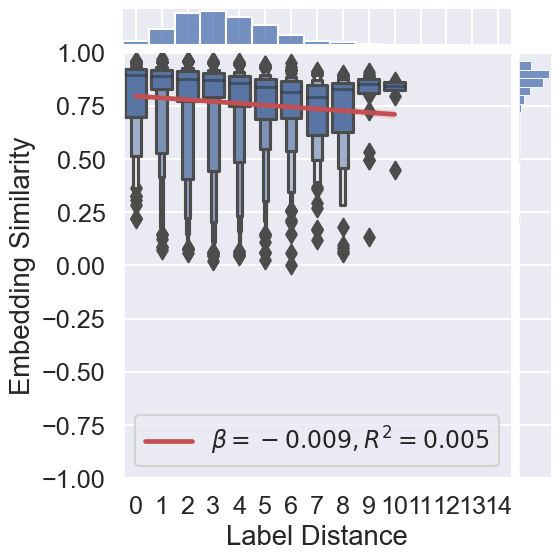

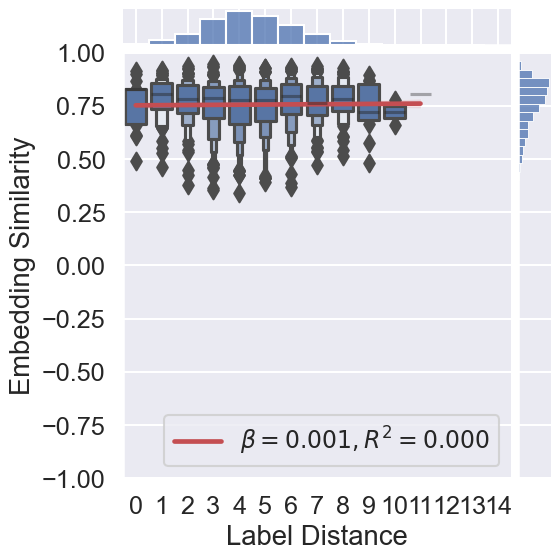

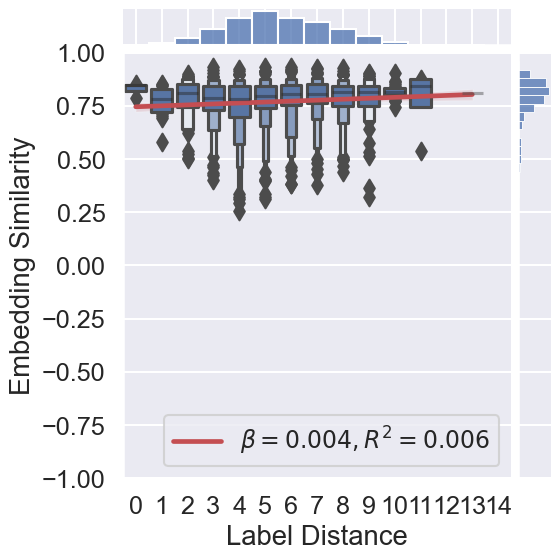

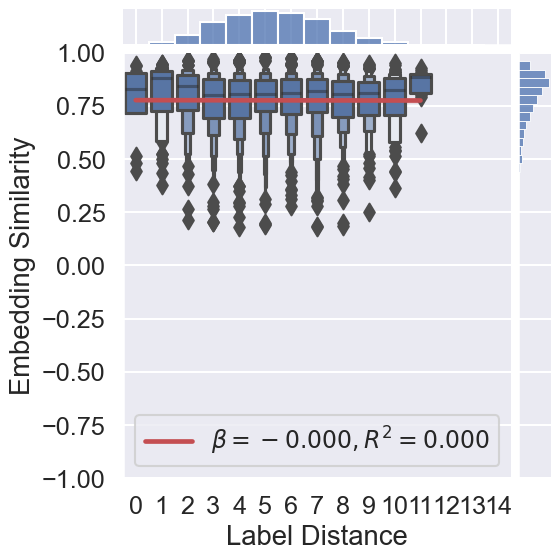

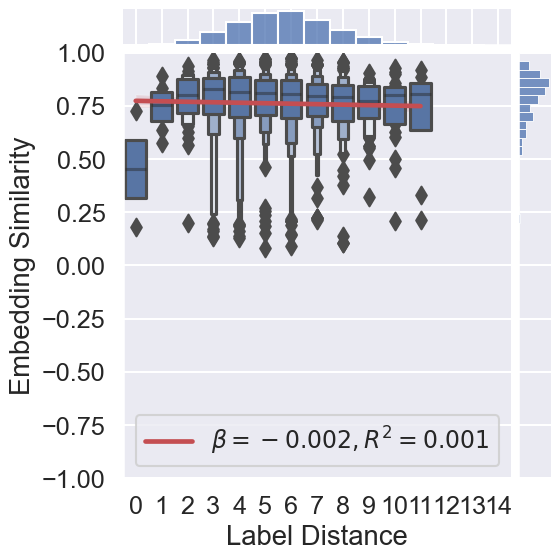

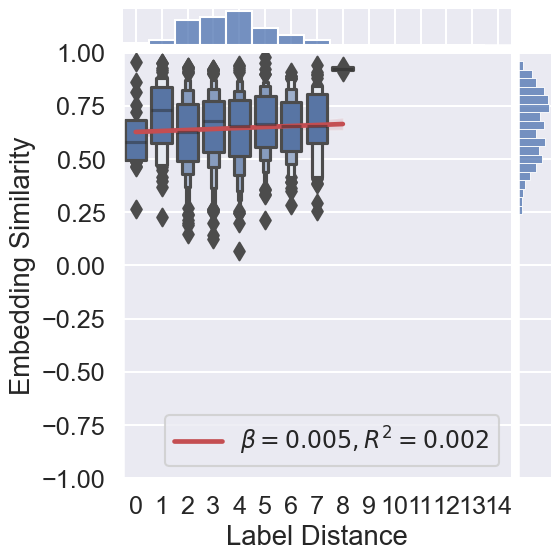

In [9]:
model_untrained = AutoModel.from_pretrained(model_name)
for language in LANGUAGES:
    dm = load_datamanager(language)
    trainer_untrained = load_trainer(model_untrained, dm)
    print(f'Plotting {language} untrained')
    plot_pairwise(trainer_untrained.compute_embeddings(dm.get_head_eval_dataset()))
    plt.savefig(f"./embeddings_similarities_{language}_untrained.pdf", bbox_inches='tight')

file_suffix 00
0.08627940944788291
file_suffix 25
0.0
file_suffix 50
0.0
file_suffix en_epoch_50
3.036264644704403e-206
file_suffix fr_epoch_50
9.738643015076332e-36
file_suffix ge_epoch_50
4.219939667961131e-14
file_suffix it_epoch_50
2.4307167326299323e-30
file_suffix po_epoch_50
8.187558544115966e-17
file_suffix ru_epoch_50
3.079963247468527e-20


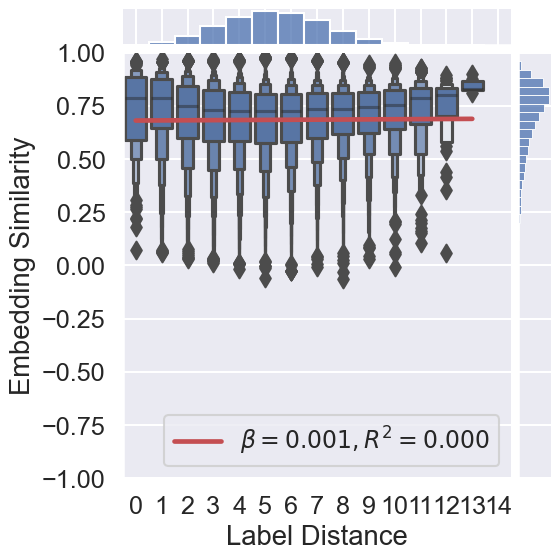

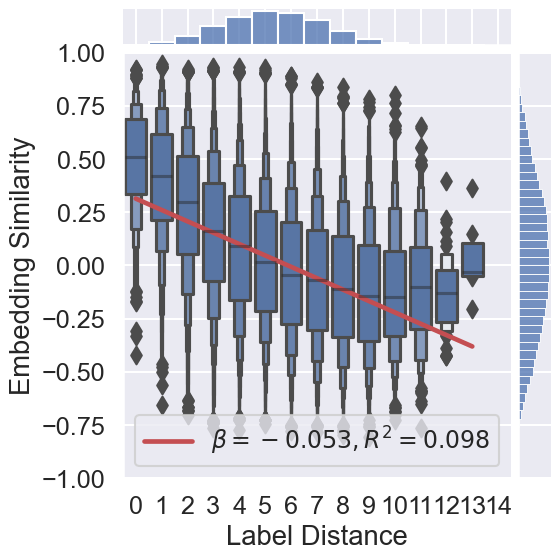

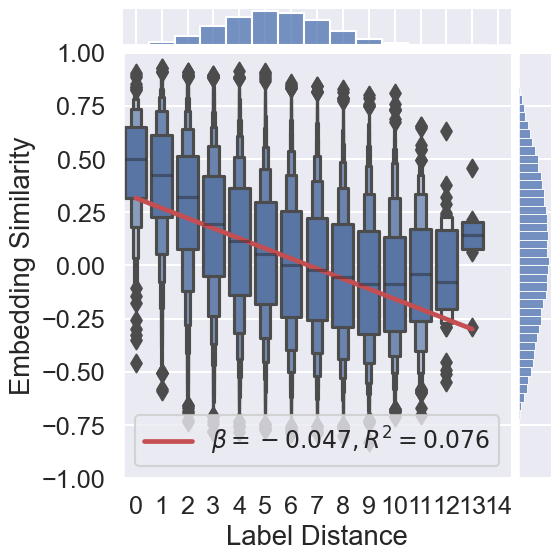

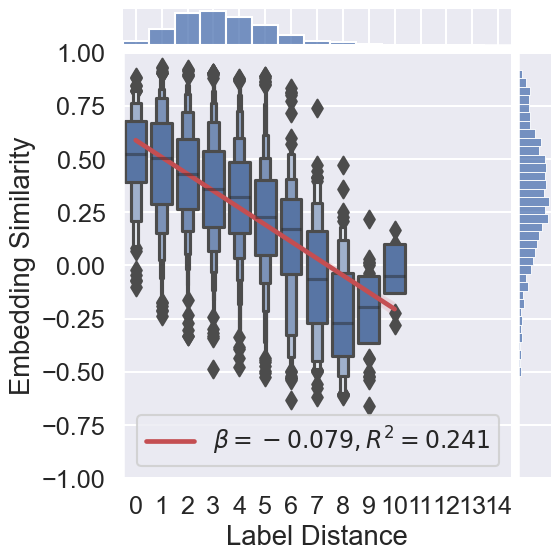

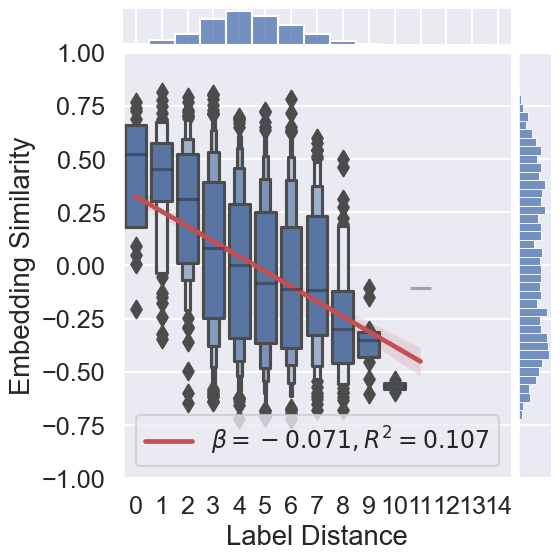

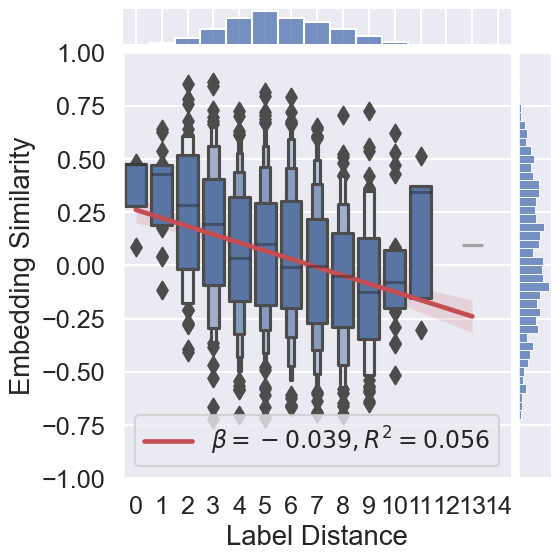

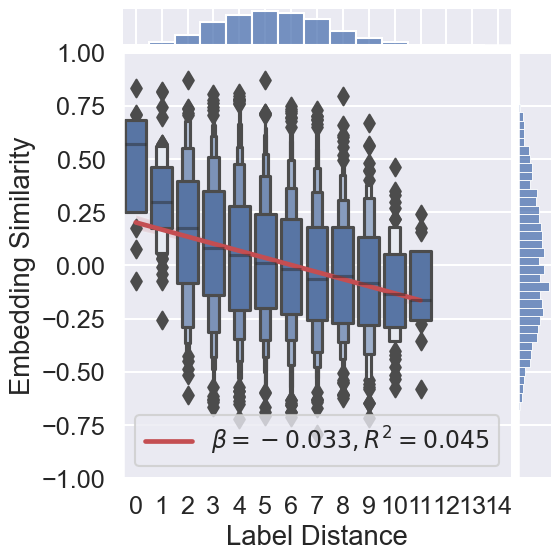

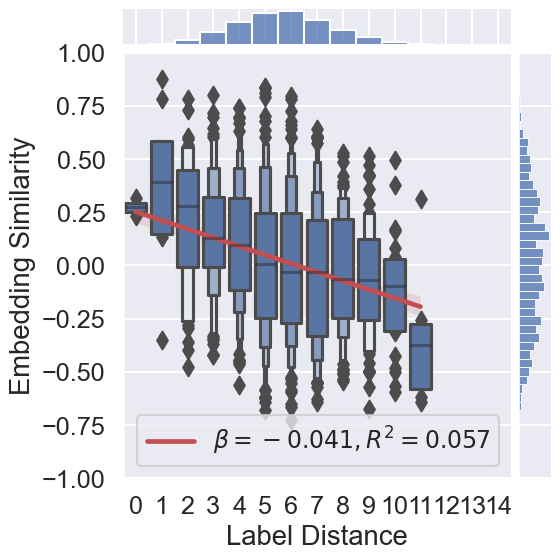

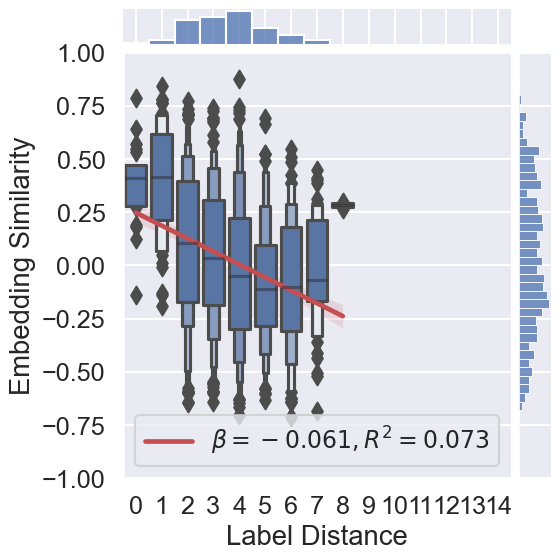

In [10]:
for file_suffix in ["00", "25", "50", "en_epoch_50", "fr_epoch_50", "ge_epoch_50", "it_epoch_50", "po_epoch_50", "ru_epoch_50"]:
    print("file_suffix", file_suffix)
    plot_from_embedding_file(f"dev_embeddings/embeddings_{file_suffix}.pickle")
    plt.savefig(f"./embeddings_similarities_{file_suffix}.pdf", bbox_inches='tight')